# EDA on underreporting vs actual crime and PAS measures

---

In [122]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import datetime as dt

In [123]:
# load data with preprocessing
df = pd.read_pickle(r"PAS_underreporting.pkl")
df = df[df["Question"] != 'XQ59CD']  # removing unnecessary question
df = df.replace({'-': np.nan, ' ': np.nan, '': np.nan, '#N/A': np.nan})  # make unknown NAN
df = df.dropna()

### Notes for the PAS underreporting dataset

Only questions **BQ90D** and **BQ90DA** make sense to ask and were asked from 2015 to the beginning of 2021. We will only look at them for plotting. 

This dataset shows underreporting by ward. Most ``no_counts`` were 4 and most ``total_counts`` were 18. There is an additional column ``Total_no_prop`` to show how much a ward contributed to overall underreporting in that quartile for the entire London.

Not all boroughs are listed. 66 entries do not have a borough listed => _dropped rows_.

In [124]:
# Print simple statistics
print(df.shape)
print(df.describe())
print(df.head(20))
print(df.columns)

for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("---------------------------------------------------------------")

(6901, 8)
       total_count     no_count  Proportion_no  Total_prop_no
count  6901.000000  6901.000000    6901.000000    6901.000000
mean      1.313143     0.368932       0.277815       0.000106
std       0.617651     0.550454       0.417131       0.000159
min       1.000000     0.000000       0.000000       0.000000
25%       1.000000     0.000000       0.000000       0.000000
50%       1.000000     0.000000       0.000000       0.000000
75%       1.000000     1.000000       0.500000       0.000258
max       6.000000     3.000000       1.000000       0.000969
    Year-Month               Borough                            ward_n   
0   2015-04-01  Barking and Dagenham                         Becontree  \
1   2015-04-01  Barking and Dagenham                          Eastbury   
2   2015-04-01  Barking and Dagenham                             Heath   
3   2015-04-01  Barking and Dagenham                          Parsloes   
4   2015-04-01                Barnet                         B

In [125]:
# How often does each borough show up here?
print(df["Borough"].value_counts().sort_values(ascending=False))

Borough
Hackney                   261
Enfield                   249
Richmond upon Thames      242
Lewisham                  242
Camden                    241
Hounslow                  235
Haringey                  233
Waltham Forest            232
Barnet                    232
Islington                 228
Merton                    227
Brent                     224
Redbridge                 221
Kingston upon Thames      219
Lambeth                   213
Hillingdon                213
Southwark                 212
Harrow                    212
Ealing                    211
Wandsworth                207
Hammersmith and Fulham    207
Sutton                    206
Tower Hamlets             203
Croydon                   201
Newham                    198
Bexley                    196
Westminster               195
Greenwich                 194
Bromley                   194
Kensington and Chelsea    188
Havering                  183
Barking and Dagenham      182
Name: count, dtype: int64


In [126]:
# DF underreporting by borough + print stats
df_ub = df.groupby(["Year-Month", "Borough"])[["total_count", "no_count", "Total_prop_no"]].sum().reset_index()
print(df_ub.describe())
print("total_count:", sum(df_ub["total_count"]), "\nno_count:", sum(df_ub["no_count"]), "\nTotal_prop_no:", sum(df_ub["Total_prop_no"]))

       total_count     no_count  Total_prop_no
count  2156.000000  2156.000000    2156.000000
mean      4.203154     1.180891       0.000339
std       2.289998     1.158736       0.000345
min       1.000000     0.000000       0.000000
25%       2.000000     0.000000       0.000000
50%       4.000000     1.000000       0.000258
75%       6.000000     2.000000       0.000517
max      17.000000     8.000000       0.002583
total_count: 9062 
no_count: 2546 
Total_prop_no: 0.7313411578596984


In [127]:
# max underreporting borough -> 0.2%
print("MAX BOROUGH")
print(df_ub.max())
print("---------------------")
print(df_ub[df_ub.Total_prop_no == df_ub.Total_prop_no.max()])
print("------------------------------------------------------")
# max underreporting ward -> 5 wards tied with 0.000969 contribution to underreporting in London City
print("MAX WARDS")
print(df.max())
print("---------------------")
print(df[df.Total_prop_no == df.Total_prop_no.max()])

MAX BOROUGH
Year-Month        2021-03-01
Borough          Westminster
total_count               17
no_count                   8
Total_prop_no       0.002583
dtype: object
---------------------
      Year-Month                 Borough  total_count  no_count  Total_prop_no
2046  2020-12-01  Kensington and Chelsea           17         8       0.002583
------------------------------------------------------
MAX WARDS
Year-Month        2021-03-01
Borough          Westminster
ward_n              Yiewsley
Question              BQ90DA
total_count                6
no_count                   3
Proportion_no            1.0
Total_prop_no       0.000969
dtype: object
---------------------
      Year-Month                 Borough       ward_n Question  total_count   
4705  2020-01-01                 Croydon  Broad Green   BQ90DA            3  \
4820  2020-02-01  Hammersmith and Fulham        Askew   BQ90DA            3   
4877  2020-03-01                  Barnet    Colindale   BQ90DA            6   


---

## PAS dataset

In [128]:
df_pas = pd.read_pickle(r"crime_data/PAS.pkl")
df_pas['Date'] = pd.to_datetime(df_pas['Date']).dt.date
df_pas = df_pas[["Date", "Borough", "Measure", "Proportion"]].copy()
print(df_pas)

            Date               Borough            Measure  Proportion
0     2023-12-31  Barking and Dagenham   "Good Job" local        0.48
1     2023-12-31                Barnet   "Good Job" local        0.47
2     2023-12-31                Bexley   "Good Job" local        0.54
3     2023-12-31                 Brent   "Good Job" local        0.49
4     2023-12-31               Bromley   "Good Job" local        0.51
...          ...                   ...                ...         ...
9307  2014-12-31                Sutton  Understand issues        0.79
9308  2014-12-31         Tower Hamlets  Understand issues        0.63
9309  2014-12-31        Waltham Forest  Understand issues        0.79
9310  2014-12-31            Wandsworth  Understand issues        0.71
9311  2014-12-31   City of Westminster  Understand issues        0.77

[9312 rows x 4 columns]


---

## Crime dataset

We will plot the total number of crimes against the number of underreported crimes. We do not have specific crime underreporting number, so we will only use the total numbers.

In [143]:
# Load data with preprocessing
df2 = pd.read_pickle(r'crime_data/london_street_with_city.pkl')
df2 = df2[~(df2["Borough"] == 'City of London')]
df2["Year"] = df2["Year"].astype(int)
df2["Year-Month"] = pd.to_datetime(df2["Year-Month"]).dt.date

In [130]:
# Grouping by crime, Pivot table to convert Crime type into columns
def create_df(df):
    crime_counts = df.groupby(['Year-Month', 'Crime type']).size().reset_index(name='Count')
    pivot_df = crime_counts.pivot_table(index='Year-Month', columns='Crime type', values='Count', aggfunc='sum', fill_value=0)
    return pivot_df

In [131]:
pivot_df = create_df(df2)
print(pivot_df)

Crime type  Anti-social behaviour  Bicycle theft  Burglary   
Year-Month                                                   
2010-12-01                  34459              0      7897  \
2011-01-01                  33542              0      9020   
2011-02-01                  32070              0      7774   
2011-03-01                  35794              0      8313   
2011-04-01                  40922              0      7596   
...                           ...            ...       ...   
2023-09-01                  21196           1650      4517   
2023-10-01                  20034           1537      4541   
2023-11-01                  17668           1160      4681   
2023-12-01                  16322            915      4957   
2024-01-01                  16505            956      5043   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft   
Year-Month                                                               
2010-12-01                          0      0 

In [132]:
def plotter(pivot_df, title_name):
    plt.figure(figsize=(12, 6))
    plt.stackplot(pivot_df.index, pivot_df.values.T, labels=pivot_df.columns)
    plt.title(f'Crime Counts Over Time in {title_name}')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

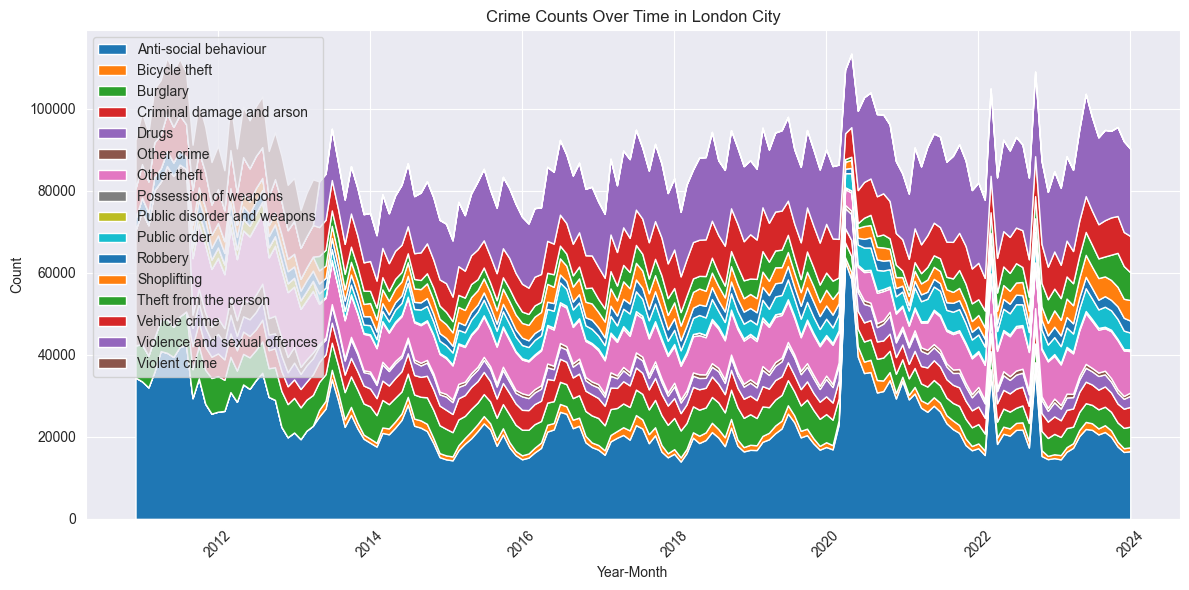

In [133]:
# Plotting total crime by crime
plotter(pivot_df, "London City")

In [134]:
# # Plotting crime by borough
# for B in df2["Borough"].unique():
#     print(B)
#     df_borough = df2[df2["Borough"] == B]
#     plotter(create_df(df_borough), B)

In [135]:
# Grouping by total crime per quartile by borough
df_london = df2.groupby(['Borough', 'Year-Month']).size().to_frame('num_crimes').reset_index()
df_london

,Borough,Year-Month,num_crimes
0,Barking and Dagenham,2010-12-01,2044
1,Barking and Dagenham,2011-01-01,2292
2,Barking and Dagenham,2011-02-01,2171
3,Barking and Dagenham,2011-03-01,2505
4,Barking and Dagenham,2011-04-01,2743
...,...,...,...
5051,Wandsworth,2023-09-01,2852
5052,Wandsworth,2023-10-01,3001
5053,Wandsworth,2023-11-01,2700
5054,Wandsworth,2023-12-01,2716


In [136]:
# Create the plot
fig = px.line(df_london, x='Year-Month', y='num_crimes', color='Borough', 
              title='Number of Crimes per Borough Over Time')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Crimes',
    legend_title='Borough',
    template='plotly_white',
    width=1200,
    height=800
)

# Show the plot
fig.show()

# Final plot

---

## Borough level

C:\Users\20223084\AppData\Local\Temp\ipykernel_9556\4091579977.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



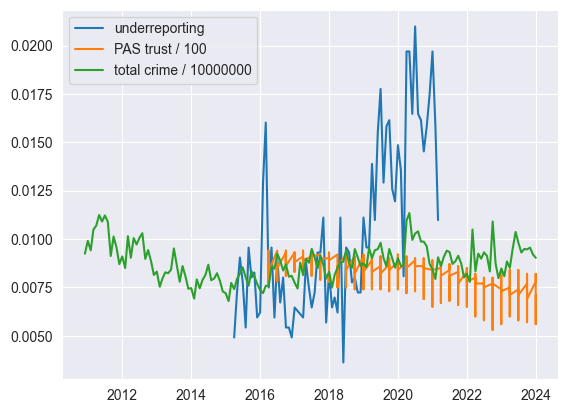

In [137]:
# New dataframes
df_trust = df_pas[df_pas["Measure"] == "Trust MPS"]
df_crime = df_london.groupby("Year-Month")["num_crimes"].sum().reset_index()
df_under = df_ub.groupby("Year-Month")["Total_prop_no"].sum().reset_index()

# New columns for plotting
df_trust["Trust / 100"] = df_trust["Proportion"] / 100
df_crime["Crime / 10000000"] = df_crime["num_crimes"] / 10000000

plt.plot(df_under["Year-Month"], df_under["Total_prop_no"], label="underreporting")
plt.plot(df_trust["Date"], df_trust["Trust / 100"], label="PAS trust / 100")
plt.plot(df_crime["Year-Month"], df_crime["Crime / 10000000"], label="total crime / 10000000")
plt.legend(loc='upper left')
plt.show()

## Ward level

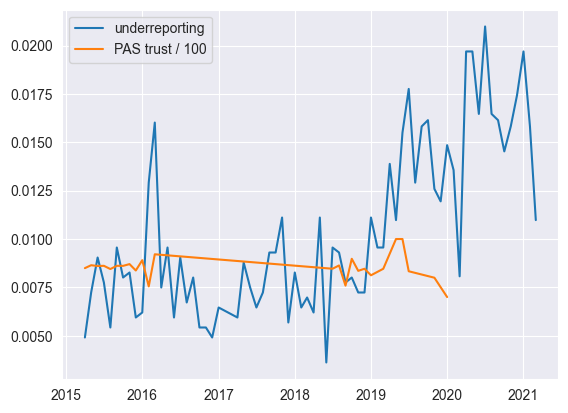

In [147]:
# Loading data and creating new columns
df_load = pd.read_pickle(r"crime_data\PAS_ward.pkl")
df_load = df_load[df_load["Measure"] == "Trust MPS"]

df_under_ward = df.groupby("Year-Month")["Total_prop_no"].sum().reset_index()
df_pas_ward = df_load.groupby("Year-Month")["Proportion"].mean().reset_index()  # taking average instead of sum
df_pas_ward["Trust / 100"] = df_pas_ward["Proportion"] / 100

plt.plot(df_under_ward["Year-Month"], df_under_ward["Total_prop_no"], label="underreporting")
plt.plot(df_pas_ward["Year-Month"], df_pas_ward["Trust / 100"], label="PAS trust / 100")
plt.legend(loc='upper left')
plt.show()